<a href="https://colab.research.google.com/github/sayan0506/Tensorflow-Advanced-Techniques-Specialization/blob/main/Building_a_model_for_the_Energy_Efficiency_data_using_Kera_Functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# checking tensorflow version
try:
  # tensorflow_version only exists in collab
  %tensorflow_version 2.x
except Exception:
  pass

In [73]:
# Importing modules
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.vis_utils import plot_model

# label formatting
def format_output(data):
  y1 = data.pop('Y1')
  y1 = np.array(y1)
  y2 = data.pop('Y2')
  y2 = np.array(y2)
  # we must transpose the output metrices here
  return y1.transpose(), y2.transpose()


In [74]:
# normalizing inputs
def norm(x):
  return (x - train_stats['mean'])/train_stats['std']

In [87]:
# true and predicted value plots
def plot_diff(y_true, y_pred, title = ""):
  plt.scatter(y_true, y_pred)
  plt.title(title)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-100, 100], [-100,100])
  plt.show()

# training metrices plot of the model
def plot_metrics(metric_name, title, ylim = 5):
  # y axis shows the loss
  plt.title(title)
  plt.ylim(0, ylim)
  plt.plot(history.history[metric_name], color = 'blue', label = metric_name)
  plt.plot(history.history['val_'+metric_name], color = 'green', label = 'val_' + metric_name)
  plt.show()

In [76]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
# using pandas excel_reader to create dataframe from data in that url
df = pd.read_excel(URL)
# frac : float, optional, Fraction of axis items to return. Cannot be used with n.
df = df.sample(frac=1).reset_index(drop = True)

In [77]:
# splitting the data into 80% train, 20% test data
train, test = train_test_split(df, test_size = 0.2)
train_stats = train.describe() 

# get two outputs from Y1 and Y2 and format them as numpy arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_y = format_output(train)
test_y = format_output(test)

# normalize the training and test data
norm_train_x = norm(train)
norm_test_x = norm(test)
print(norm_train_x)
print(norm_test_x)
print(len(train_y))

           X1        X2        X3  ...        X6        X7        X8
302  0.525276 -0.670427 -0.012918  ... -1.341142 -1.014778  1.428796
501 -1.353114  1.542702  1.120212  ... -1.341142 -1.014778 -1.143875
209 -0.226080  0.159497 -1.712614  ...  0.450939 -1.014778  0.142461
61  -0.038241 -0.117144  2.253342  ...  0.450939 -1.014778  0.142461
512  0.525276 -0.670427 -0.012918  ... -0.445101  1.214466  1.428796
..        ...       ...       ...  ...       ...       ...       ...
288  2.027989 -1.776991 -0.579484  ... -0.445101 -1.014778  0.142461
638 -1.353114  1.542702  1.120212  ...  1.346979  1.214466  1.428796
62  -0.977436  0.989420 -0.012918  ...  1.346979  1.214466  0.785628
104 -0.038241 -0.117144  2.253342  ...  0.450939  1.214466 -1.143875
103  0.243518 -0.393785  0.553647  ...  1.346979  0.099844  0.142461

[614 rows x 8 columns]
           X1        X2        X3  ...        X6        X7        X8
429  0.900954 -0.947068 -0.579484  ... -1.341142 -1.014778 -1.143875
754 -0.695

In [78]:
# defining the Model layers using Keras fuctional API
input_layer = Input(shape = (len(train .columns),))
first_dense = Dense(units = '128', activation = 'relu')(input_layer)
second_dense = Dense(units = '128', activation = 'relu')(first_dense)

# Y1 output will be fed directly from second dense
y1_output = Dense(units = '1', name = 'y1_output')(second_dense)
third_dense = Dense(units = '64', activation = 'relu')(second_dense)

# Y2 output will come via third dense, y2 is the regression output, a quantitative value
y2_output = Dense(units = '1', name = 'y2_output')(third_dense)

[Use of Underscores in Python](https://www.datacamp.com/community/tutorials/role-underscore-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034358&utm_targetid=aud-763347114660:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9301106&gclid=CjwKCAiA8Jf-BRB-EiwAWDtEGr3AgGKL8AaP5XVtxBm18meFL7iGyghLMsz_0M9soStcgXRddIqg8BoCiQ0QAvD_BwE#SLU)

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 128)          1152        input_7[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 128)          16512       dense_19[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 64)           8256        dense_20[0][0]                   
______________________________________________________________________________________

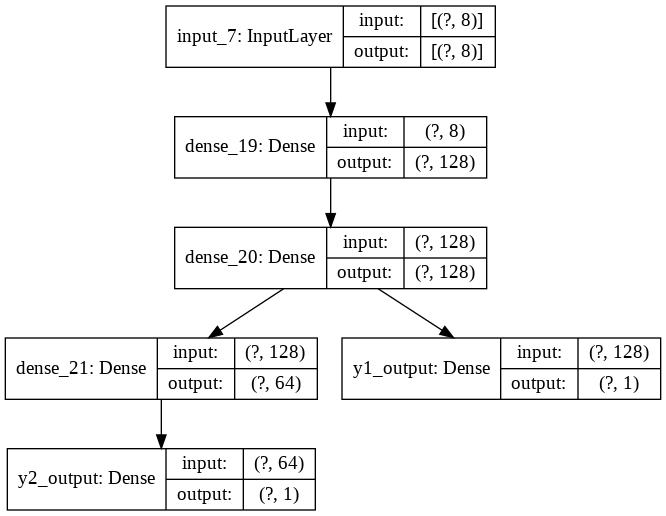

In [79]:
# Define the Model with the input layer and list of output layers
model = Model(inputs = input_layer, outputs = [y1_output, y2_output])
print(model.summary()) 

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr = 0.001)
model.compile(optimizer = optimizer, 
              # defining the loss functions for both the outputs indivdually
              loss = {'y1_output': 'mse', 'y2_output': 'mse'},
              metrics = {'y1_output':tf.keras.metrics.RootMeanSquaredError(),
                         'y2_output':tf.keras.metrics.RootMeanSquaredError()})


from tensorflow.keras.layers import Layer

# obtaining a list of layers
# we are taking it manually to avoid that, sometimes keras add empty layers to model.layers
model._layers = [layer for layer in model._layers if isinstance(layer, Layer)]

plot_model(model)
plot_model(model, show_shapes = True, show_layer_names=True, to_file = 'model.jpg')

Epoch 1/1000
62/62 [==============================] - 0s 3ms/step - loss: 0.2894 - y1_output_loss: 0.1089 - y2_output_loss: 0.1804 - y1_output_root_mean_squared_error: 0.3300 - y2_output_root_mean_squared_error: 0.4248 - val_loss: 0.5370 - val_y1_output_loss: 0.1546 - val_y2_output_loss: 0.3823 - val_y1_output_root_mean_squared_error: 0.3932 - val_y2_output_root_mean_squared_error: 0.6183
Epoch 2/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.1314 - y1_output_loss: 0.0636 - y2_output_loss: 0.0677 - y1_output_root_mean_squared_error: 0.2523 - y2_output_root_mean_squared_error: 0.2602 - val_loss: 0.4958 - val_y1_output_loss: 0.1478 - val_y2_output_loss: 0.3481 - val_y1_output_root_mean_squared_error: 0.3844 - val_y2_output_root_mean_squared_error: 0.5900
Epoch 3/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.1093 - y1_output_loss: 0.0553 - y2_output_loss: 0.0540 - y1_output_root_mean_squared_error: 0.2352 - y2_output_root_mean_squared_error: 0.23

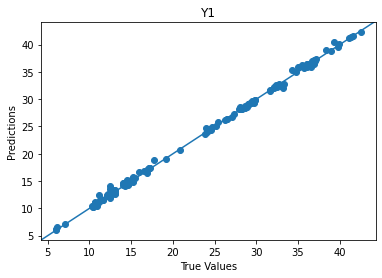

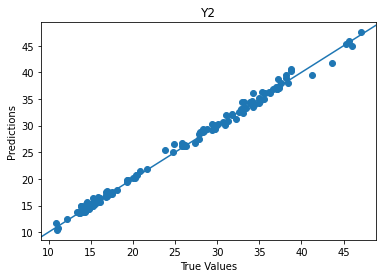

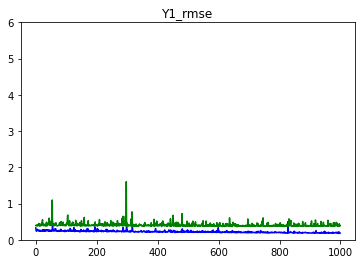

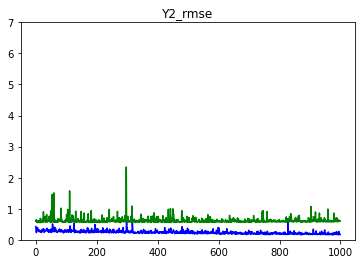

In [95]:
# train the model for 100 epochs
history = model.fit(norm_train_x, train_y, epochs = 1000, batch_size = 10, validation_data = (norm_test_x, test_y))

# test the model and print loss and mse for for both outputs
loss, y1_loss, y2_loss, y1_rmse, y2_rmse = model.evaluate(x = norm_test_x, y = test_y)

# plot loss and mse
y_pred = model.predict(norm_test_x)
plot_diff(test_y[0], y_pred[0], title = 'Y1')
plot_diff(test_y[1], y_pred[1], title = 'Y2')
plot_metrics(metric_name = 'y1_output_root_mean_squared_error', title = 'Y1_rmse', ylim = 6)
plot_metrics(metric_name = 'y2_output_root_mean_squared_error', title = 'Y2_rmse', ylim = 7)


In [96]:
history.history.keys()

dict_keys(['loss', 'y1_output_loss', 'y2_output_loss', 'y1_output_root_mean_squared_error', 'y2_output_root_mean_squared_error', 'val_loss', 'val_y1_output_loss', 'val_y2_output_loss', 'val_y1_output_root_mean_squared_error', 'val_y2_output_root_mean_squared_error'])